In [1]:
'''batched toy environment for testing the policy gradient with batches
this time PG object changed so that returns are biased at each step'''

'batched toy environment for testing the policy gradient with batches\nthis time PG object changed so that returns are biased at each step'

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent
from rl_networks import create_actor_network_test_v1

from test_envs import BatchMountainCarContinuous 

import types
config = types.SimpleNamespace()
config.batch_size = 32
# config.margin = 20
# config.image_h = 224
# config.image_w = 224
# config.image_hm = config.image_h+2*config.margin
# config.image_wm = config.image_w+2*config.margin
# config.foveate = None
# config.do_grayscale = True
# config.history_length = 16
# config.t_ignore = 16
# config.t_max =50
# config.motion_mode = 'velocity'
# config.use_dones = False

# config.gym_mode = False
# t_vec = np.linspace(0,150,16)

# balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
# config.filter = balanced_filter.reshape([1,1,-1,1])
# config.min_freq = 1
# config.max_freq = 13
# config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

# dataset = get_dataset(dataset_dir,
#                                      'validation',
#                                      config.batch_size,
#                                      image_h = config.image_hm,
#                                      image_w = config.image_wm,
#                                      preprocessing='identity',
#                                      rggb_mode=False,
#                                      central_squeeze_and_pad_factor=-1)

# # env = RetinaEnv(config, image_generator=dataset)
# env = RetinaEnv(config) #freezing on first batch
# for images,_ in dataset:
#     break
    
env =  BatchMountainCarContinuous(batch_size=config.batch_size)




# actor_model = create_actor_model(env.image_h, env.image_w,
#                                  env.spectral_density_size, env.location_history_size,
#                                  env.timestep_size, env.action_size)
actor_model = create_actor_network_test_v1((2,), 15.0)

actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=10.,model=actor_model,action_dim=1)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_states = env.reset()
    episodic_rewards = 0
    states_rec, actions_rec, rewards_rec, masks_rec = [], [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)
    masks = np.ones(config.batch_size)
    while True:

        deterministic_actions, means,stdevs = agent.get_action(prev_states,
                                               return_stats=True)
        actions = deterministic_actions #hook in order to add noise if neccessary
#         state, reward, done, info = env.step(np.reshape(action,[1]))
        states, rewards, dones, infos = env.step(actions)
        
#         if env.warmup_done:
        states_rec.append(prev_states)
        actions_rec.append(actions)
        rewards_rec.append(rewards)
        masks_rec.append(masks)
        
        episodic_rewards += rewards*masks

        #after a single done step mask is being turned off
        masks = np.logical_and(np.logical_not(dones), masks)
        #after a single done step mask is being turned off


        action_mean_records.append(deterministic_actions.mean(axis=0))
        action_var_records.append(deterministic_actions.var(axis=0))
        action_statmean_records.append(means)
        action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if np.all(dones):
            break

        prev_states = np.copy(states)
    
    agent.train(np.array(states_rec), 
                np.array(actions_rec), 
                np.array(rewards_rec), 
                masks=np.array(masks_rec,dtype=np.bool),
               max_iterations = 1000,
               loud=True)
    reward_records.append(episodic_rewards)
    print(f"Episode * {ep} * Episodic Reward is ==> {np.mean([episodic_rewards])}")
# #     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
#     print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
#     print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
#     print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
#     print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])
#     print(episodic_rewards)

Training for 150 iterations with batchsize 64
Episode * 0 * Episodic Reward is ==> -300.0
Training for 145 iterations with batchsize 64
Episode * 1 * Episodic Reward is ==> -288.53125
Training for 108 iterations with batchsize 64
Episode * 2 * Episodic Reward is ==> -170.0
Training for 64 iterations with batchsize 64
Episode * 3 * Episodic Reward is ==> -41.46875
Training for 39 iterations with batchsize 64
Episode * 4 * Episodic Reward is ==> 19.46875
Training for 54 iterations with batchsize 64
Episode * 5 * Episodic Reward is ==> -7.84375
Training for 33 iterations with batchsize 64
Episode * 6 * Episodic Reward is ==> 33.40625
Training for 44 iterations with batchsize 64
Episode * 7 * Episodic Reward is ==> 11.9375
Training for 41 iterations with batchsize 64
Episode * 8 * Episodic Reward is ==> 18.875
Training for 33 iterations with batchsize 64
Episode * 9 * Episodic Reward is ==> 34.1875
Training for 32 iterations with batchsize 64
Episode * 10 * Episodic Reward is ==> 36.625
Tr

Training for 10 iterations with batchsize 64
Episode * 91 * Episodic Reward is ==> 79.65625
Training for 10 iterations with batchsize 64
Episode * 92 * Episodic Reward is ==> 80.4375
Training for 10 iterations with batchsize 64
Episode * 93 * Episodic Reward is ==> 79.21875
Training for 10 iterations with batchsize 64
Episode * 94 * Episodic Reward is ==> 79.9375
Training for 10 iterations with batchsize 64
Episode * 95 * Episodic Reward is ==> 80.8125
Training for 10 iterations with batchsize 64
Episode * 96 * Episodic Reward is ==> 80.15625
Training for 11 iterations with batchsize 64
Episode * 97 * Episodic Reward is ==> 78.875
Training for 10 iterations with batchsize 64
Episode * 98 * Episodic Reward is ==> 79.21875
Training for 10 iterations with batchsize 64
Episode * 99 * Episodic Reward is ==> 80.1875
Training for 11 iterations with batchsize 64
Episode * 100 * Episodic Reward is ==> 78.78125
Training for 10 iterations with batchsize 64
Episode * 101 * Episodic Reward is ==> 8

Training for 9 iterations with batchsize 64
Episode * 181 * Episodic Reward is ==> 81.375
Training for 9 iterations with batchsize 64
Episode * 182 * Episodic Reward is ==> 81.90625
Training for 9 iterations with batchsize 64
Episode * 183 * Episodic Reward is ==> 81.28125
Training for 9 iterations with batchsize 64
Episode * 184 * Episodic Reward is ==> 81.84375
Training for 9 iterations with batchsize 64
Episode * 185 * Episodic Reward is ==> 81.9375
Training for 9 iterations with batchsize 64
Episode * 186 * Episodic Reward is ==> 81.5625
Training for 9 iterations with batchsize 64
Episode * 187 * Episodic Reward is ==> 81.46875
Training for 9 iterations with batchsize 64
Episode * 188 * Episodic Reward is ==> 81.6875
Training for 9 iterations with batchsize 64
Episode * 189 * Episodic Reward is ==> 82.03125
Training for 9 iterations with batchsize 64
Episode * 190 * Episodic Reward is ==> 82.53125
Training for 9 iterations with batchsize 64
Episode * 191 * Episodic Reward is ==> 82

KeyboardInterrupt: 

In [4]:
import misc

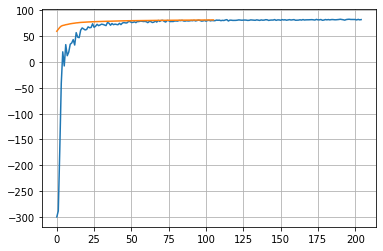

In [5]:
reward_records = np.array(reward_records)
plt.plot(reward_records.mean(axis=1))
plt.plot(misc.smooth(reward_records.mean(axis=1),100))
plt.grid()


(50.0, 100.0)

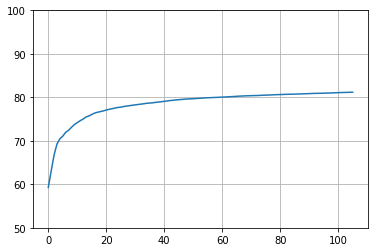

In [6]:
# plt.plot(reward_records)
plt.plot(misc.smooth(reward_records.mean(axis=1),100))
plt.grid()
plt.ylim([50,100])